In [1]:
from gurobipy import Model, GRB, quicksum
import pandas as pd

# Load data
tasks = pd.read_csv("./open_v2/task.csv")
# tasks= tasks[:20]
agvs = pd.read_csv("./open_v2/agv.csv")
# agvs = agvs[:5]
# === Parameters & sets ===
depot = (0, 0)
points = [(idx + 1, row['x'], row['y']) for idx, row in tasks.iterrows()]
points = [(0, *depot)] + points + [(len(points) + 1, *depot)]

distance = {
    i_idx: {
        j_idx: abs(i_x - j_x) + abs(i_y - j_y)
        for j_idx, j_x, j_y in points
    }
    for i_idx, i_x, i_y in points
}

NODE = len(tasks) + 2
K = list(range(len(agvs)))
N = list(range(1, len(points) - 1))
N_s = list(range(0, len(points) - 1))
N_t = list(range(0, len(points)))
N_s_t = list(range(0, len(points)))
T_max = [4 for _ in range(len(agvs))]

v = agvs['speed_cells_per_sec'].tolist()
Q = agvs['capacity'].tolist()
D = agvs['max_distance'].tolist()
s = [0] + tasks['service_time'].tolist() + [0]
u = [0] + tasks['demand'].tolist() + [0]
deadlines = [0] + tasks['deadline'].tolist() + [0]
demand_max = max(tasks['demand'])
dead_line_max = max(tasks['deadline'])
M = 1000
alpha, beta = 1, 2

In [ ]:
# === Build Gurobi model ===
model = Model("Corrected_AGV_Routing")
x, y, o, t = {}, {}, {}, {}

for k in K:
    for r in range(T_max[k]):
        for i in N_s_t:
            for j in N_s_t:
                if i != j:
                    x[k, i, j, r] = model.addVar(vtype=GRB.BINARY, name=f"x_{k}_{i}_{j}_{r}")
        for i in N_s_t:
            y[k, i, r] = model.addVar(vtype=GRB.BINARY, name=f"y_{k}_{i}_{r}")
            o[k, i, r] = model.addVar(vtype=GRB.INTEGER, name=f"o_{k}_{i}_{r}")
            t[k, i, r] = model.addVar(vtype=GRB.CONTINUOUS, name=f"t_{k}_{i}_{r}")

late = {}
for i in N:
    late[i] = model.addVar(vtype=GRB.CONTINUOUS, name=f"late_{i}")

model.update()

# === Constraints ===

# 1. Start depot only once
for k in K:
    model.addConstr(quicksum(x[k, 0, j, 0] for j in N ) == 1)
    for r in range(0, T_max[k]):
        model.addConstr(quicksum(x[k, 0, j, r] for j in N ) <= quicksum(x[k, j,N_t[-1], r] for j in N ))

for k in K:
    for r in range(T_max[k]):
        for j in N:
            model.addConstr(quicksum(x[k, i, j, r] for i in N_s if i != j ) == quicksum(x[k, j, i, r] for i in N_t if i != j ))


for k in K:
    for r in range(T_max[k]):
        for j in N_t:
            model.addConstr(quicksum(x[k, i, j, r] for i in N_s if i != j ) == y[k, j, r])

# 3. Time sequencing (big-M)
for k in K:
    for r in range(T_max[k]):
        for i in N_s:
            for j in N_t:
                if i != j :
                    model.addConstr(
                        t[k, j, r] >= t[k, i, r] + distance[i][j] / v[k] + s[i] - M * (1 - x[k, i, j, r])
                    )

# 4. Demand served only if visited
for k in K:
    for r in range(T_max[k]):
        for i in N:
            model.addConstr(o[k, i, r] == u[i] * y[k, i, r])

# 5. Capacity constraint
for k in K:
    for r in range(T_max[k]):
        model.addConstr(quicksum(o[k, i, r] for i in N) <= Q[k])
        

# 6. Distance constraint
for k in K:
    for r in range(T_max[k]):
        model.addConstr(quicksum(distance[i][j] * x[k, i, j, r] for i in N_s_t for j in N_s_t if i != j ) <= D[k])

# 7. Each task must be served at least once
for j in N:
    model.addConstr(quicksum(y[k, j, r] for k in K for r in range(T_max[k])) == 1)

# 8. Start times are 0
for k in K:
    model.addConstr(t[k, 0, 0] == 0)

for k in K:
    for r in range(T_max[k]):
        for i in N:
            model.addConstr(late[i] >= t[k, i, r] - deadlines[i])
            model.addConstr(late[i] >= 0)

for k in K:
    for r in range(1, T_max[k]):
            model.addConstr(t[k, N_t[-1], r-1] <= t[k, 0, r] )
for k in K:
    for r in range(0, T_max[k]):
            model.addConstr(t[k, 0, r] <= t[k,  N_t[-1], r] )

tardiness = quicksum(late[i] for i in N)

travel_cost = quicksum(
    (distance[i][j] / v[k]) * x[k, i, j, r]
    for k in K for r in range(T_max[k])
    for i in N_s_t for j in N_s_t
    if i != j
)
model.addConstr(alpha * travel_cost + beta * tardiness >= 5000)
# === Objective ===
model.setObjective(alpha * travel_cost + beta * tardiness, GRB.MINIMIZE)
model.setParam(GRB.Param.TimeLimit, 3600*3)
# model.Params.MIPFocus     = 1       # lean to finding high-quality incumbents quickly
# model.Params.Presolve     = 2  
# === Solve ===

USER_UB = 9000
model.setParam(GRB.Param.Cutoff, USER_UB)

model.optimize()

Set parameter Username
Set parameter LicenseID to value 2636023
Academic license - for non-commercial use only - expires 2026-03-13
Set parameter TimeLimit to value 10800
Set parameter Cutoff to value 9000
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-14700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 28 logical processors, using up to 28 threads

Non-default parameters:
Cutoff  9000
TimeLimit  10800

Optimize a model with 642596 rows, 636580 columns and 4952185 nonzeros
Model fingerprint: 0x2dd735a5
Variable types: 6220 continuous, 630360 integer (624240 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [5e-01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 21225 rows and 16275 columns (presolve time = 5s)...
Presolve removed 21225 rows and 16275 columns (presolve time = 10s)...
Presolve removed 21225 rows and 16275 c

In [ ]:
# === AGV 별 전체 경로 문자열로 저장 ===
from collections import defaultdict

# 경로 재구성
agv_routes = defaultdict(lambda: defaultdict(list))  # agv_routes[k][r] = [(i, j)]

if model.status in [GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.INTERRUPTED]:
    for k in K:
        for r in range(T_max[k]):
            arcs = []
            for i in N_s_t:
                for j in N_s_t:
                    if i != j and (k, i, j, r) in x and x[k, i, j, r].X > 0.5:
                        arcs.append((i, j))
            if arcs:
                agv_routes[k][r] = arcs

    # 각 AGV별 경로 정렬 및 문자열화
    final_paths = []
    for k in agv_routes:
        full_path = []
        used = set()
        for r in sorted(agv_routes[k].keys()):
            arcs = agv_routes[k][r]
            # 경로를 순서대로 정렬
            route = []
            current = 0  # depot에서 시작
            while True:
                next_nodes = [j for (i, j) in arcs if i == current and (i, j) not in used]
                if not next_nodes:
                    break
                next_node = next_nodes[0]
                route.append(next_node)
                used.add((current, next_node))
                current = next_node
            # 노드 이름 포맷 변경: 0 → DEPOT, others → T 00XX
            formatted = ["DEPOT"]
            for node in route:
                if node == 0 or node == len(N_s_t) - 1:
                    formatted.append("DEPOT")
                else:
                    formatted.append(f"T{node:04d}")
            full_path.extend(formatted)

        # 중복 DEPOT 제거
        clean_path = [full_path[0]]
        for node in full_path[1:]:
            if node != "DEPOT" or clean_path[-1] != "DEPOT":
                clean_path.append(node)

        final_paths.append({
            "agv_id": f"A{k+1:03d}",
            "route": ",".join(clean_path)
        })

    # CSV 저장
    path_df = pd.DataFrame(final_paths)
    output_path = "0930_agv_routes_formatted_2.csv"
    path_df.to_csv(output_path, index=False)
    print(f"📁 AGV 경로가 저장되었습니다: {output_path}")
else:
    print("⚠️ 최적 해를 찾지 못했기 때문에 경로를 저장하지 않습니다.")



AttributeError: Unable to retrieve attribute 'X'

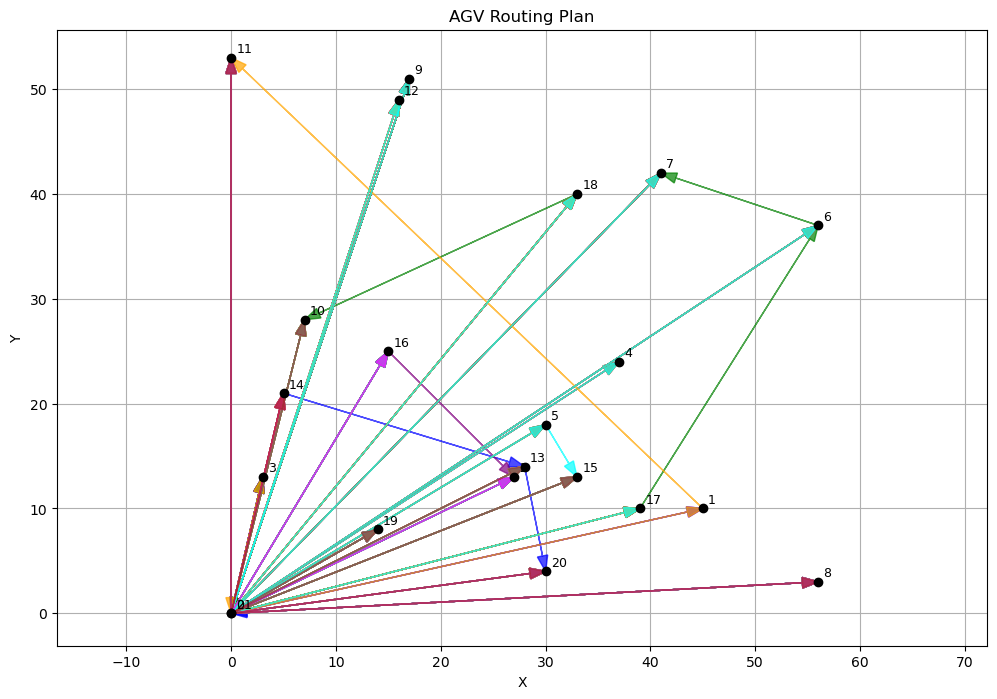

In [ ]:
import matplotlib.pyplot as plt

# 좌표 dict로 변환 (노드 번호 → (x, y))
coord = {i: (x, y) for i, x, y in points}

plt.figure(figsize=(12, 8))

# 모든 노드를 scatter
for i, (xi, yi) in coord.items():
    plt.scatter(xi, yi, c='black', zorder=3)
    plt.text(xi + 0.5, yi + 0.5, f"{i}", fontsize=9)

colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'brown']

for k in K:
    for r in range(T_max[k]):
        route_color = colors[(k * 3 + r) % len(colors)]
        for i in coord:
            for j in coord:
                if i != j and (k, i, j, r) in x:
                    if x[k, i, j, r].X > 0.5:
                        xi, yi = coord[i]
                        xj, yj = coord[j]
                        plt.arrow(xi, yi, xj - xi, yj - yi, 
                                    head_width=1, length_includes_head=True, 
                                    color=route_color, alpha=0.7, zorder=2)
        plt.plot([], [], color=route_color, label=f"AGV {k}, Route {r}")

plt.title("AGV Routing Plan")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
# plt.legend()
plt.axis("equal")
plt.show()



In [ ]:
t

{(0, 0, 0): <gurobi.Var t_0_0_0 (value 0.0)>,
 (0, 1, 0): <gurobi.Var t_0_1_0 (value 17.5)>,
 (0, 2, 0): <gurobi.Var t_0_2_0 (value 7.0)>,
 (0, 3, 0): <gurobi.Var t_0_3_0 (value 2.0)>,
 (0, 4, 0): <gurobi.Var t_0_4_0 (value 8.5)>,
 (0, 5, 0): <gurobi.Var t_0_5_0 (value 6.0)>,
 (0, 6, 0): <gurobi.Var t_0_6_0 (value 24.5)>,
 (0, 7, 0): <gurobi.Var t_0_7_0 (value 19.5)>,
 (0, 8, 0): <gurobi.Var t_0_8_0 (value 26.5)>,
 (0, 9, 0): <gurobi.Var t_0_9_0 (value 13.0)>,
 (0, 10, 0): <gurobi.Var t_0_10_0 (value 6.5)>,
 (0, 11, 0): <gurobi.Var t_0_11_0 (value 22.5)>,
 (0, 12, 0): <gurobi.Var t_0_12_0 (value 12.5)>,
 (0, 13, 0): <gurobi.Var t_0_13_0 (value 127.0)>,
 (0, 14, 0): <gurobi.Var t_0_14_0 (value 13.0)>,
 (0, 15, 0): <gurobi.Var t_0_15_0 (value 0.0)>,
 (0, 16, 0): <gurobi.Var t_0_16_0 (value 1.0)>,
 (0, 17, 0): <gurobi.Var t_0_17_0 (value 9.5)>,
 (0, 18, 0): <gurobi.Var t_0_18_0 (value 14.5)>,
 (0, 19, 0): <gurobi.Var t_0_19_0 (value 0.0)>,
 (0, 20, 0): <gurobi.Var t_0_20_0 (value 194.0)>,

In [ ]:
for k in K:
    for r in range(T_max[k]):
        for i in N_s_t:
            for j in N_s_t:
                if i != j and x[k,i,j,r].x > 0.5:
                    print(k,r,i,j)

0 0 0 14
0 0 13 20
0 0 14 13
0 0 20 21
0 0 21 3
0 0 21 6
0 0 21 7
0 0 21 8
0 0 21 9
0 0 21 11
0 0 21 12
0 0 21 13
0 0 21 14
0 0 21 15
0 0 21 16
0 0 21 17
0 0 21 18
0 0 21 19
0 0 21 20
0 1 0 17
0 1 6 7
0 1 7 21
0 1 17 6
0 1 21 3
0 1 21 5
0 1 21 6
0 1 21 7
0 1 21 8
0 1 21 9
0 1 21 10
0 1 21 11
0 1 21 15
0 1 21 17
0 1 21 18
0 1 21 19
0 1 21 20
0 2 21 3
0 2 21 4
0 2 21 5
0 2 21 7
0 2 21 8
0 2 21 9
0 2 21 10
0 2 21 11
0 2 21 12
0 2 21 13
0 2 21 14
0 2 21 15
0 2 21 17
0 2 21 18
0 2 21 19
0 2 21 20
0 3 0 4
0 3 4 21
0 3 21 3
0 3 21 7
0 3 21 15
0 3 21 18
1 0 0 16
1 0 2 21
1 0 16 2
1 1 21 2
1 1 21 3
1 1 21 4
1 1 21 5
1 1 21 7
1 1 21 8
1 1 21 9
1 1 21 10
1 1 21 11
1 1 21 12
1 1 21 13
1 1 21 14
1 1 21 15
1 1 21 16
1 1 21 17
1 1 21 18
1 1 21 19
1 1 21 20
1 2 0 5
1 2 5 15
1 2 15 21
1 2 21 2
1 2 21 3
1 2 21 4
1 2 21 6
1 2 21 7
1 2 21 8
1 2 21 10
1 2 21 11
1 2 21 14
1 2 21 15
1 2 21 16
1 2 21 17
1 2 21 19
1 3 0 12
1 3 12 21
1 3 21 3
2 0 0 3
2 0 3 21
2 0 21 1
2 0 21 3
2 0 21 8
2 0 21 9
2 0 21 11
2 0 21

In [ ]:
T_max[1]

4